# **Convolutional Neural Network based FER**

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from torch.autograd import Variable

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(48),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_path = '/content/images/train'
valid_path = '/content/images/validation'

train_dataset = datasets.ImageFolder(train_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
for batch in train_loader:
    X_train, y_train = batch
    break

for batch in valid_loader:
    X_test, y_test = batch
    break

X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

eyes_train = X_train[:, :, int(48/6):int(48/2), :]
mouths_train = X_train[:, :, int(48*(2/3)):, :]

eyes_test = X_test[:, :, int(48/6):int(48/2), :]
mouths_test = X_test[:, :, int(48*(2/3)):, :]

##Visualisation of Images

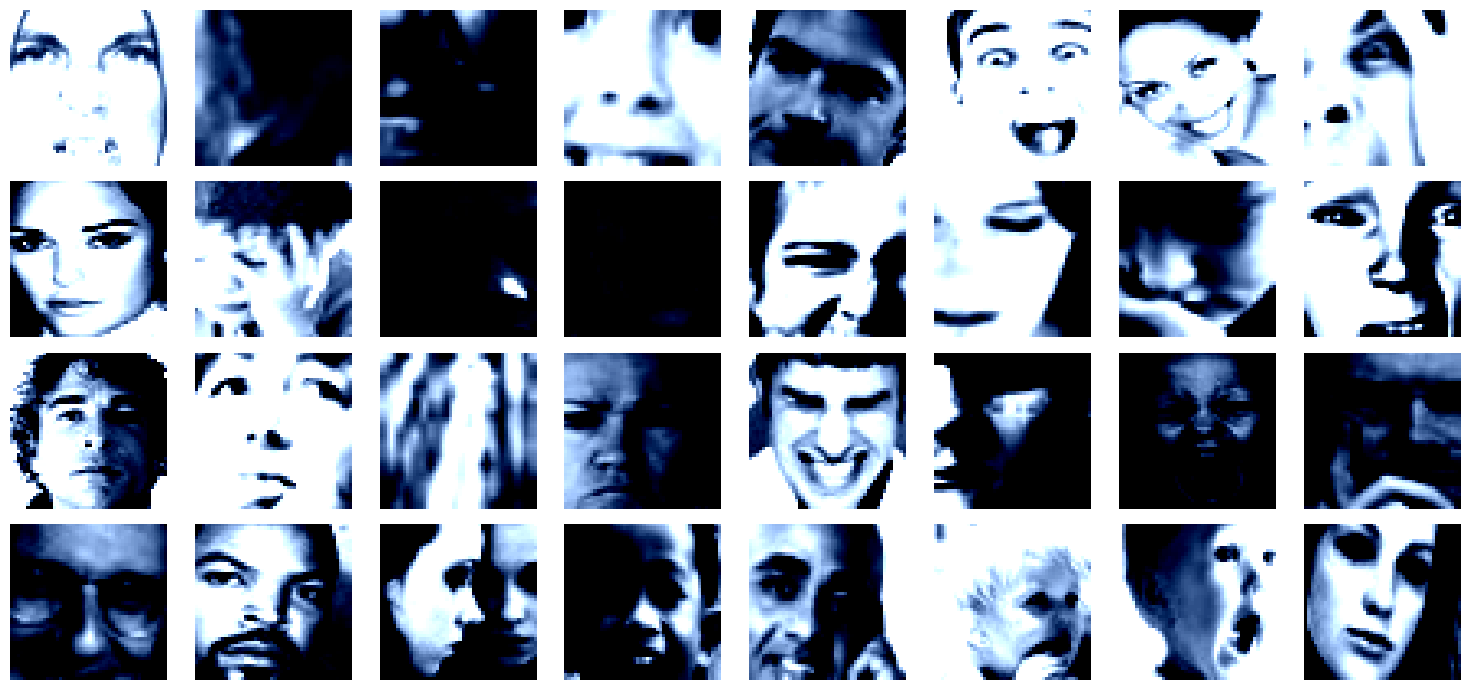

In [ ]:
images = X_train

rows = 4
cols = 8
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 7))

for i in range(rows):
    for j in range(cols):
        if img_count < len(images):
            image_to_plot = images[img_count]
            image_to_plot = torch.clamp(image_to_plot, 0, 1)
            axes[i, j].imshow(image_to_plot.permute(1, 2, 0))
            axes[i, j].axis('off')
            img_count += 1
        else:
            break

plt.tight_layout()
plt.show()

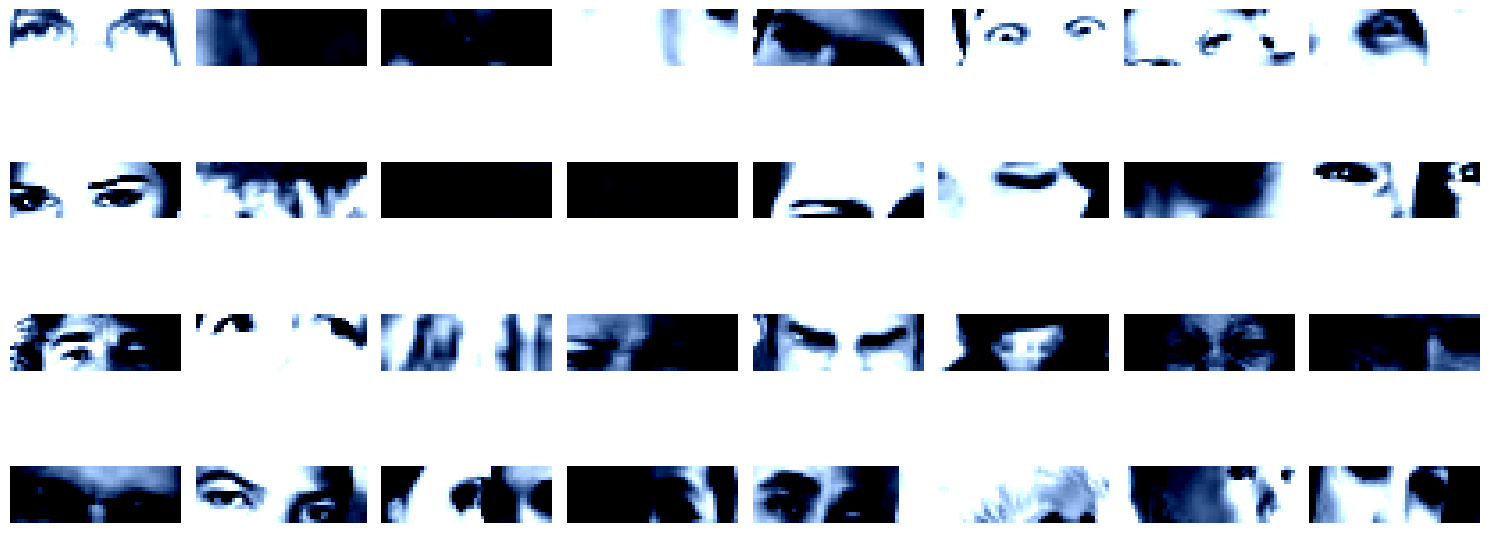

In [ ]:
images = eyes_train

rows = 4
cols = 8
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 7))

for i in range(rows):
    for j in range(cols):
        if img_count < len(images):
            image_to_plot = images[img_count]
            image_to_plot = torch.clamp(image_to_plot, 0, 1)
            axes[i, j].imshow(image_to_plot.permute(1, 2, 0))
            axes[i, j].axis('off')
            img_count += 1
        else:
            break

plt.tight_layout()
plt.show()

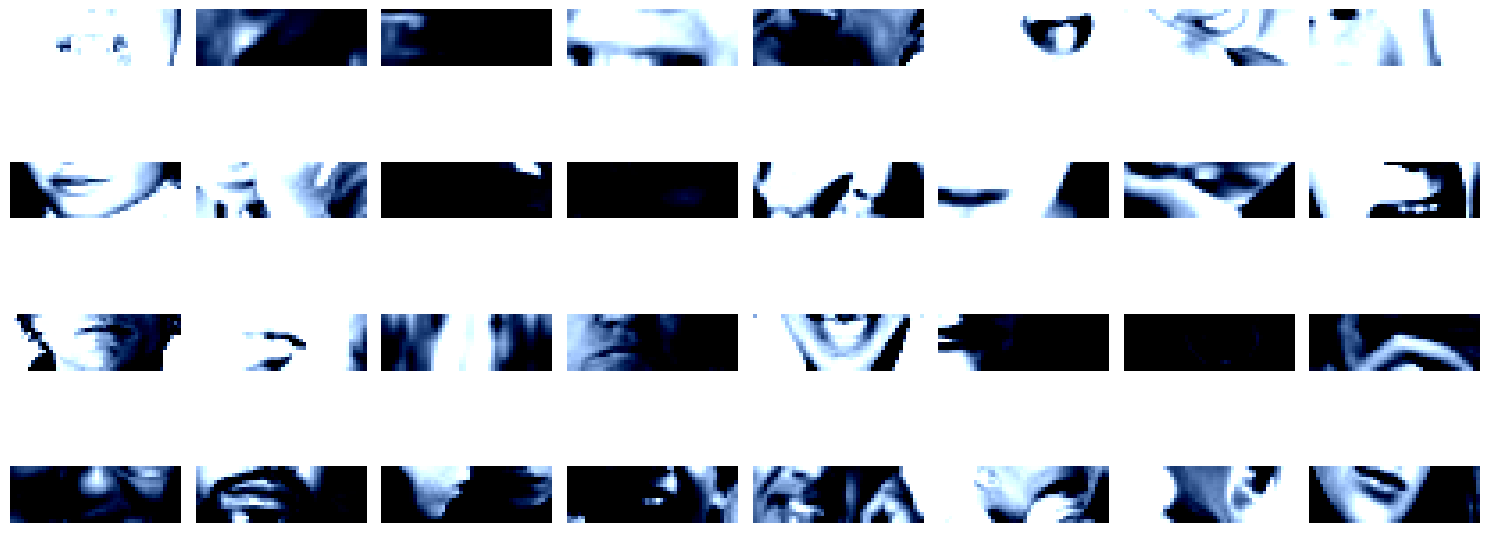

In [ ]:
#Plot mouth
images = mouths_train

rows = 4
cols = 8
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 7))

for i in range(rows):
    for j in range(cols):
        if img_count < len(images):
            image_to_plot = images[img_count]
            image_to_plot = torch.clamp(image_to_plot, 0, 1)
            axes[i, j].imshow(image_to_plot.permute(1, 2, 0))
            axes[i, j].axis('off')
            img_count += 1
        else:
            break

plt.tight_layout()
plt.show()

In [ ]:
num_train = 28709
num_test = 3589
batch_size = 128
num_epoch = 10

In [ ]:
print(X_train.shape)

torch.Size([32, 3, 48, 48])


### Model

In [ ]:
learning_rate = 0.001
weight_decay = 1e-6

In [ ]:
class EMC(nn.Module):
    def __init__(self):
        super(EMC, self).__init__()
        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(32)
        )
        self.face_arch = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(512, 7)

    def forward(self, faces):
        faces = self.initial_block(faces)
        faces = self.face_arch(faces)
        faces = faces.view(faces.size(0), -1)  # Flatten
        faces = self.fc(faces)
        return faces

model = EMC().cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
best_model_state = None

def run_experiment(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10):
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation on validation set
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.cuda(), labels.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Valid Loss: {valid_loss:.4f}")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_state = model.state_dict()

    return train_losses, valid_losses

train_losses, valid_losses = run_experiment(model, criterion, optimizer, train_loader, valid_loader, num_epochs=num_epoch)

Epoch [1/10], Train Loss: 1.8350, Valid Loss: 1.8004
Epoch [2/10], Train Loss: 1.7555, Valid Loss: 1.7198
Epoch [3/10], Train Loss: 1.6779, Valid Loss: 1.6366
Epoch [4/10], Train Loss: 1.6070, Valid Loss: 1.5444
Epoch [5/10], Train Loss: 1.5492, Valid Loss: 1.5049
Epoch [6/10], Train Loss: 1.4951, Valid Loss: 1.4825
Epoch [7/10], Train Loss: 1.4590, Valid Loss: 1.4346
Epoch [8/10], Train Loss: 1.4325, Valid Loss: 1.4236
Epoch [9/10], Train Loss: 1.3998, Valid Loss: 1.3750
Epoch [10/10], Train Loss: 1.3813, Valid Loss: 1.3419


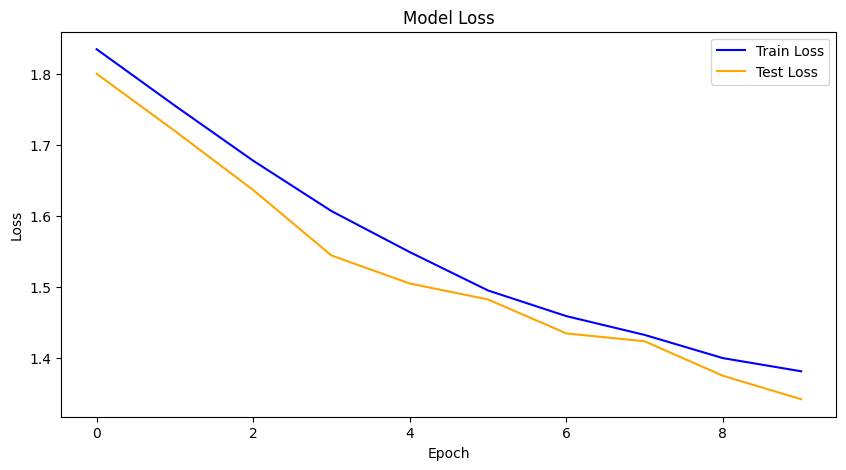

In [ ]:
def plot_model_history(train_losses, test_losses):
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming train_losses, valid_losses are lists containing loss values
plot_model_history(train_losses, valid_losses)
torch.save(best_model_state, 'best_model1.pth')

In [ ]:
def calculate_accuracy(model, data_loader):
    # Set the model to evaluation mode
    model.eval()

    correct = 0
    total = 0

    # No need to track gradients during evaluation
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move inputs and labels to GPU if available
            inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass through the model
            outputs = model(inputs)

            # Get the predicted class by finding the index of the maximum log-probability
            _, predicted = torch.max(outputs, 1)

            # Update the correct and total counts
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate the accuracy
    accuracy = correct / total * 100

    return accuracy

In [ ]:
# Calculate the accuracy of the model on the test data
test_accuracy = calculate_accuracy(model, valid_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 48.43%


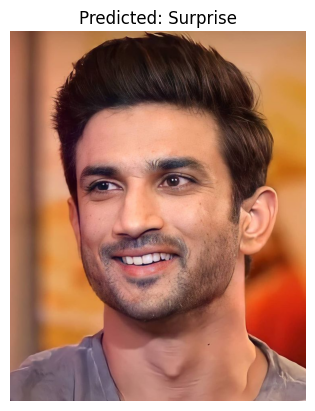

In [ ]:
from PIL import Image

model = EMC().cuda()
model.eval()

# Load and preprocess the image
image_path = '/content/ssr.jpg'
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_tensor = transform(image)

image_tensor = image_tensor.cuda()
image_tensor = image_tensor.unsqueeze(0)

with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

# Interpret the results
predicted_label = predicted.item()

label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

predicted_label_name = label_names[predicted_label]

plt.figure()
plt.imshow(image)
plt.title(f"Predicted: {predicted_label_name}")
plt.axis('off')
plt.show()


### For Mouth

In [ ]:
class EMC(nn.Module):
    def __init__(self):
        super(EMC, self).__init__()
        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(32)
        )
        self.mouth_arch = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512, 7)

    def forward(self, faces):
        faces = self.initial_block(faces)
        mouths = faces[:, :, int(24*(2/3)):, :]

        mouths = self.mouth_arch(mouths)
        mouths = mouths.view(mouths.size(0), -1)  # Flatten
        mouths = self.fc(mouths)
        return mouths

model = EMC().cuda()
best_model_state = None

Epoch [1/10], Train Loss: 1.9416, Valid Loss: 1.9433
Epoch [2/10], Train Loss: 1.9415, Valid Loss: 1.9428
Epoch [3/10], Train Loss: 1.9402, Valid Loss: 1.9419
Epoch [4/10], Train Loss: 1.9408, Valid Loss: 1.9439
Epoch [5/10], Train Loss: 1.9417, Valid Loss: 1.9436
Epoch [6/10], Train Loss: 1.9408, Valid Loss: 1.9407
Epoch [7/10], Train Loss: 1.9415, Valid Loss: 1.9432
Epoch [8/10], Train Loss: 1.9419, Valid Loss: 1.9403
Epoch [9/10], Train Loss: 1.9412, Valid Loss: 1.9425
Epoch [10/10], Train Loss: 1.9411, Valid Loss: 1.9415


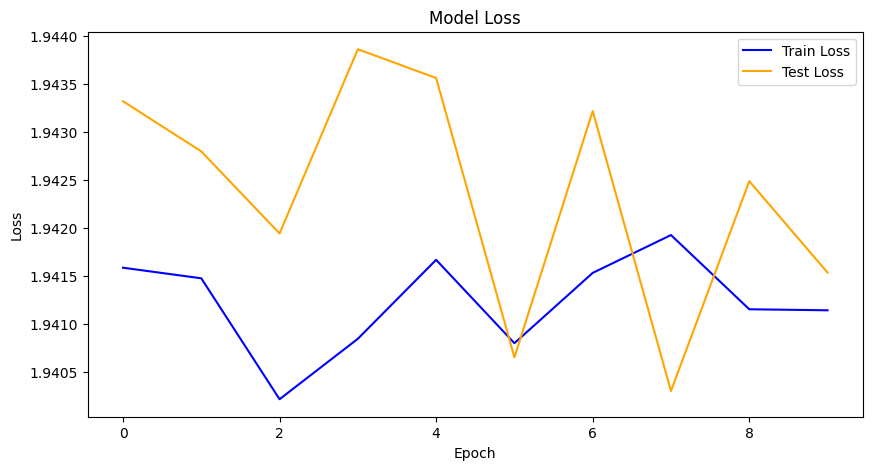

In [ ]:
train_losses, valid_losses = run_experiment(model, criterion, optimizer, train_loader, valid_loader, num_epochs=num_epoch)
plot_model_history(train_losses, valid_losses)
torch.save(best_model_state, 'best_model2.pth')

In [ ]:
# Calculate the accuracy of the model on the test data
test_accuracy = calculate_accuracy(model, valid_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 15.77%


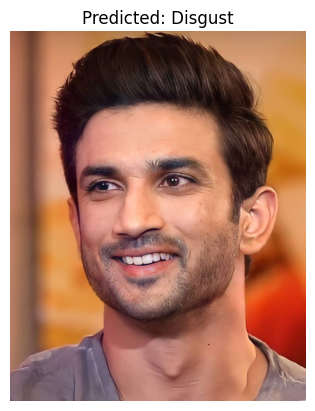

In [ ]:
model = EMC().cuda()
model.eval()

with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

# Interpret the results
predicted_label = predicted.item()
predicted_label_name = label_names[predicted_label]

plt.figure()
plt.imshow(image)
plt.title(f"Predicted: {predicted_label_name}")
plt.axis('off')
plt.show()

### For eyes

In [ ]:
class InitialBlock(nn.Module):
    def __init__(self):
        super(InitialBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

class EyesArch(nn.Module):
    def __init__(self):
        super(EyesArch, self).__init__()
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same')
        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same')
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same')
        self.conv6 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding='same')
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same')
        self.conv8 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same')
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.globalavgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.batchnorm3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.relu(x)
        x = self.batchnorm4(x)
        x = self.globalavgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class EMC(nn.Module):
    def __init__(self):
        super(EMC, self).__init__()
        self.initial_block = InitialBlock()
        self.eyes_arch = EyesArch()

    def forward(self, x):
        x = self.initial_block(x)
        x = self.eyes_arch(x)
        return x

model = EMC().cuda()
best_model_state=None

Epoch [1/10], Train Loss: 1.9708, Valid Loss: 1.9762
Epoch [2/10], Train Loss: 1.9711, Valid Loss: 1.9706
Epoch [3/10], Train Loss: 1.9697, Valid Loss: 1.9732
Epoch [4/10], Train Loss: 1.9698, Valid Loss: 1.9698
Epoch [5/10], Train Loss: 1.9711, Valid Loss: 1.9732
Epoch [6/10], Train Loss: 1.9702, Valid Loss: 1.9730
Epoch [7/10], Train Loss: 1.9702, Valid Loss: 1.9743
Epoch [8/10], Train Loss: 1.9698, Valid Loss: 1.9712
Epoch [9/10], Train Loss: 1.9709, Valid Loss: 1.9725
Epoch [10/10], Train Loss: 1.9691, Valid Loss: 1.9700


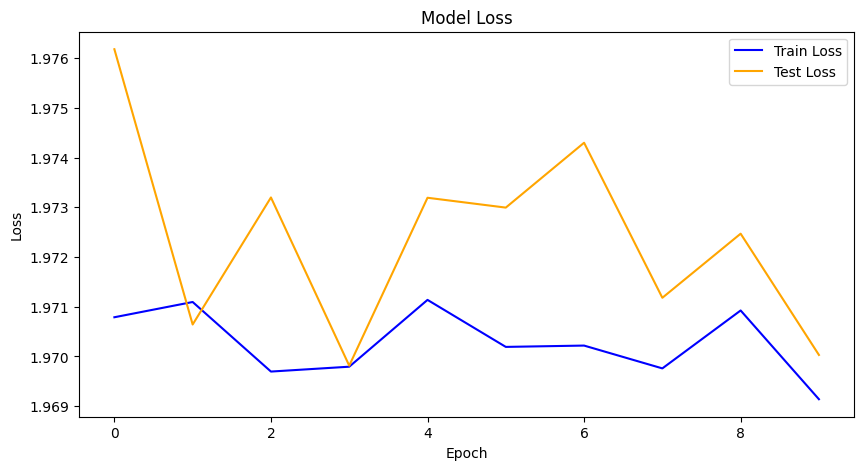

In [ ]:
train_losses, valid_losses = run_experiment(model, criterion, optimizer, train_loader, valid_loader, num_epochs=num_epoch)
plot_model_history(train_losses, valid_losses)
torch.save(best_model_state, 'best_model3.pth')

In [ ]:
# Calculate the accuracy of the model on the test data
test_accuracy = calculate_accuracy(model, valid_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 11.14%


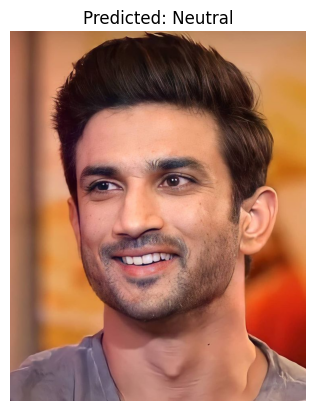

In [ ]:
model = EMC().cuda()
model.eval()

with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

# Interpret the results
predicted_label = predicted.item()
predicted_label_name = label_names[predicted_label]

plt.figure()
plt.imshow(image)
plt.title(f"Predicted: {predicted_label_name}")
plt.axis('off')
plt.show()

### For eyes and mouth

In [ ]:
class EMC(nn.Module):
    def __init__(self):
        super(EMC, self).__init__()
        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.eyes_arch = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1)
        )
        self.mouth_arch = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1)
        )
        self.output_layer = nn.Linear(1024, 7)

    def forward(self, faces):
        initial_block_output = self.initial_block(faces)
        eyes = initial_block_output[:, :, 4:12, :]
        mouths = initial_block_output[:, :, 16:24, :]

        eyes_output = self.eyes_arch(eyes)
        mouths_output = self.mouth_arch(mouths)

        eyes_output_flat = eyes_output.view(eyes_output.size(0), -1)
        mouths_output_flat = mouths_output.view(mouths_output.size(0), -1)

        concatenated_output = torch.cat([eyes_output_flat, mouths_output_flat], dim=1)
        output = self.output_layer(concatenated_output)
        return output

model = EMC().cuda()


Epoch [1/10], Train Loss: 1.9513, Valid Loss: 1.9517
Epoch [2/10], Train Loss: 1.9527, Valid Loss: 1.9521
Epoch [3/10], Train Loss: 1.9524, Valid Loss: 1.9519
Epoch [4/10], Train Loss: 1.9522, Valid Loss: 1.9521
Epoch [5/10], Train Loss: 1.9526, Valid Loss: 1.9535
Epoch [6/10], Train Loss: 1.9523, Valid Loss: 1.9509
Epoch [7/10], Train Loss: 1.9516, Valid Loss: 1.9507
Epoch [8/10], Train Loss: 1.9518, Valid Loss: 1.9511
Epoch [9/10], Train Loss: 1.9523, Valid Loss: 1.9495
Epoch [10/10], Train Loss: 1.9518, Valid Loss: 1.9521


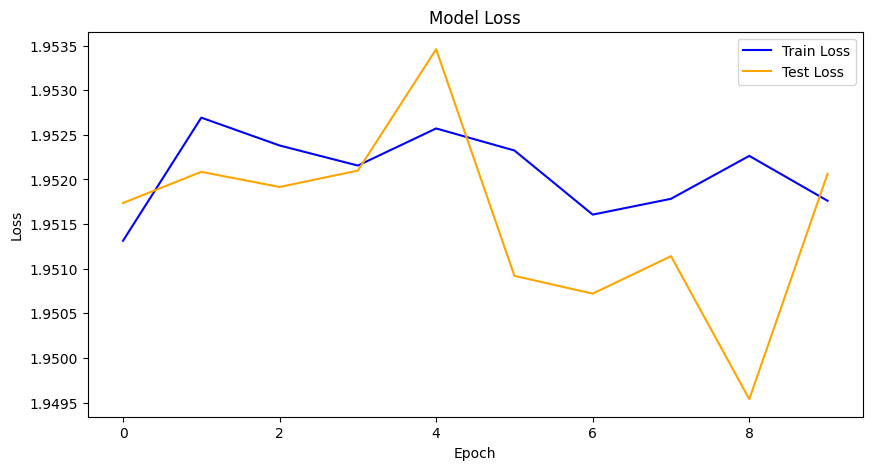

In [ ]:
train_losses, valid_losses = run_experiment(model, criterion, optimizer, train_loader, valid_loader, num_epochs=num_epoch)
plot_model_history(train_losses, valid_losses)
torch.save(best_model_state, 'best_model4.pth')

In [ ]:
# Calculate the accuracy of the model on the test data
test_accuracy = calculate_accuracy(model, valid_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 15.41%


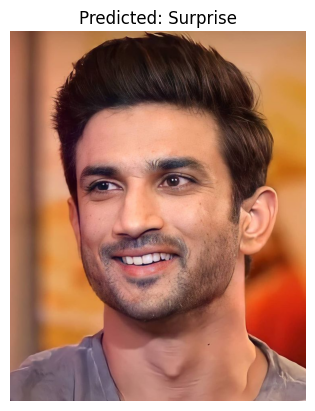

In [ ]:
model = EMC().cuda()
model.eval()

with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

# Interpret the results
predicted_label = predicted.item()

label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

predicted_label_name = label_names[predicted_label]

plt.figure()
plt.imshow(image)
plt.title(f"Predicted: {predicted_label_name}")
plt.axis('off')
plt.show()


# **Pre-Trained Models Based FER**

## **VGG-19**

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download ashishpatel26/facial-expression-recognitionferchallenge

 91% 88.0M/96.6M [00:01<00:00, 83.2MB/s]
100% 96.6M/96.6M [00:01<00:00, 80.2MB/s]


In [ ]:
!unzip facial-expression-recognitionferchallenge.zip

Archive:  facial-expression-recognitionferchallenge.zip
  inflating: Submission.csv          
  inflating: fer2013/fer2013/README  
  inflating: fer2013/fer2013/fer2013.bib  
  inflating: fer2013/fer2013/fer2013.csv  


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install scikit-plot

In [ ]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

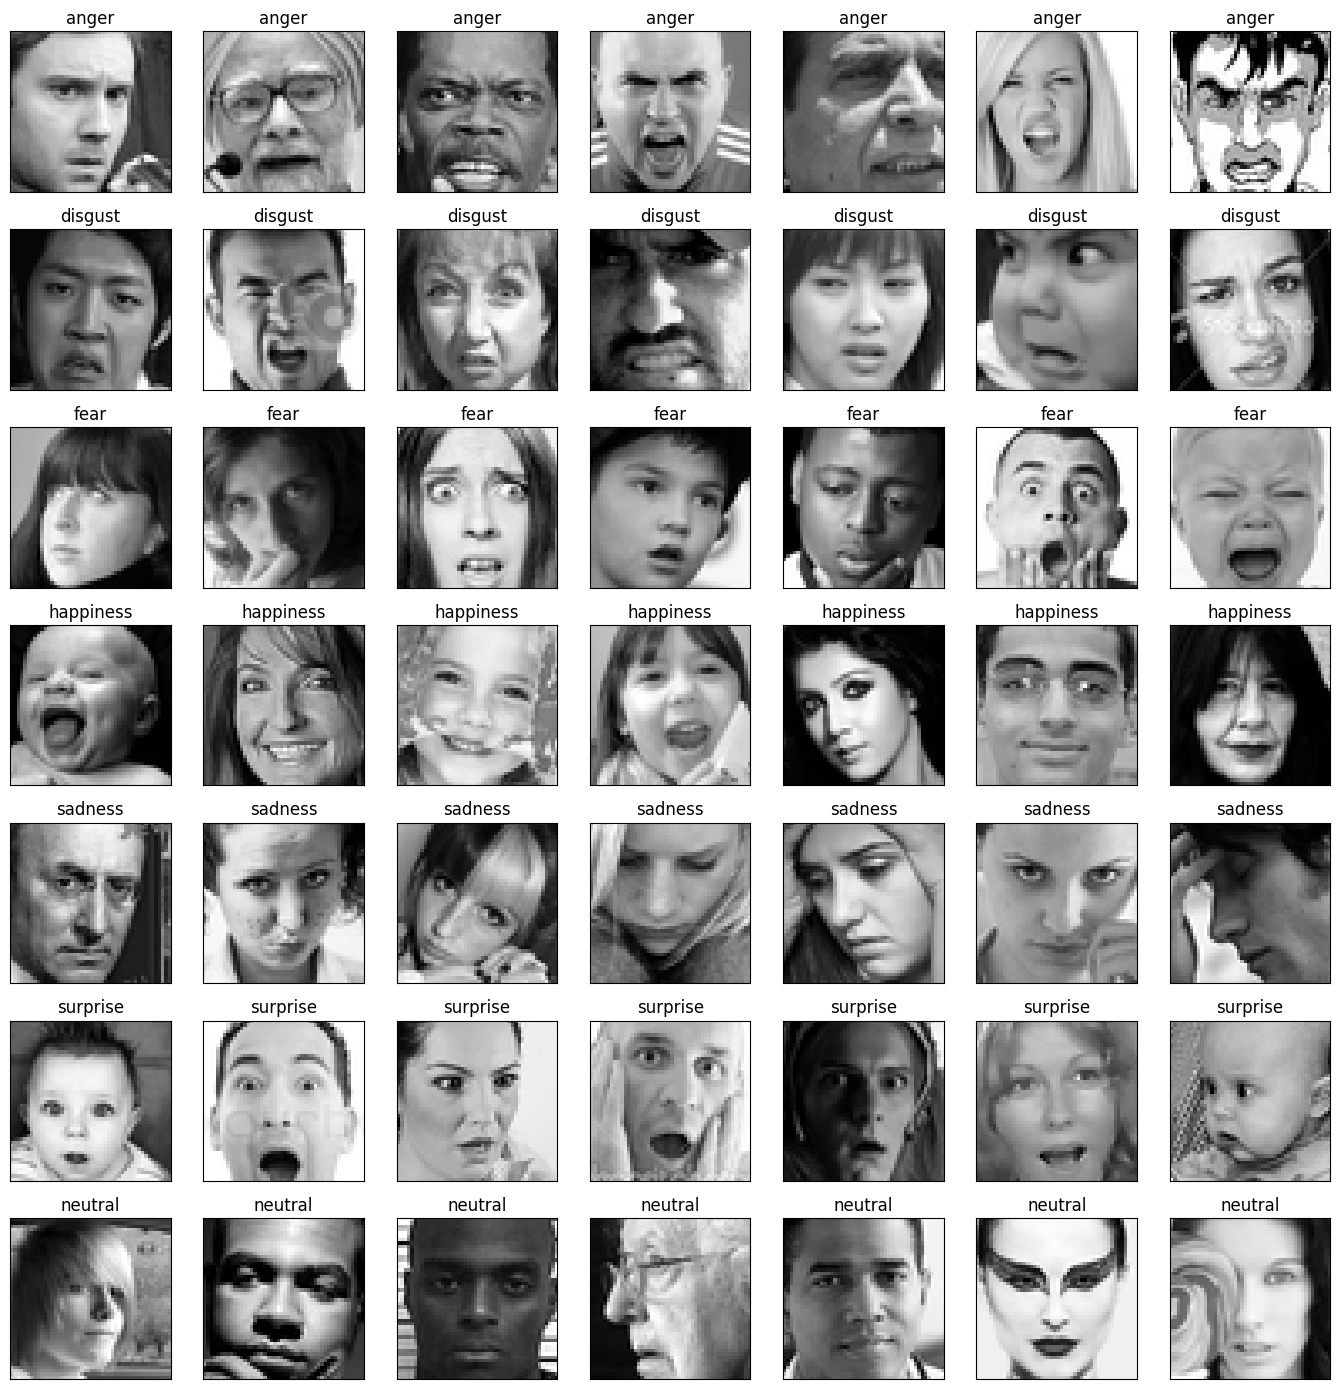

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [ ]:
img_array.shape

(35887, 48, 48)

In [ ]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


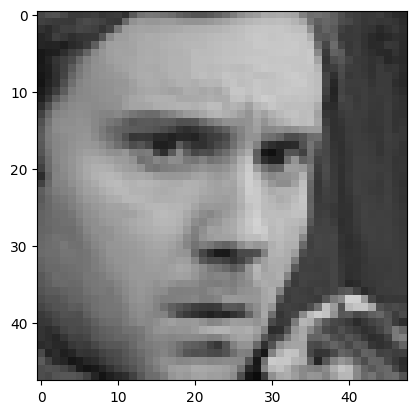

In [ ]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [ ]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle = True,
                                                      stratify = img_labels,
                                                      test_size = 0.1,
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [ ]:
del df
del img_features
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

In [ ]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/25
1009/1009 [==============================] - 70s 60ms/step - loss: 1.4528 - accuracy: 0.4348 - val_loss: 1.2290 - val_accuracy: 0.5330 - lr: 1.0000e-04
Epoch 2/25
1009/1009 [==============================] - 61s 60ms/step - loss: 1.2311 - accuracy: 0.5328 - val_loss: 1.1401 - val_accuracy: 0.5678 - lr: 1.0000e-04
Epoch 3/25
1009/1009 [==============================] - 61s 60ms/step - loss: 1.1474 - accuracy: 0.5662 - val_loss: 1.1103 - val_accuracy: 0.5832 - lr: 1.0000e-04
Epoch 4/25
1009/1009 [==============================] - 60s 59ms/step - loss: 1.0933 - accuracy: 0.5897 - val_loss: 1.0347 - val_accuracy: 0.6077 - lr: 1.0000e-04
Epoch 5/25
1009/1009 [==============================] - 59s 59ms/step - loss: 1.0500 - accuracy: 0.6034 - val_loss: 0.9971 - val_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 6/25
1009/1009 [==============================] - 59s 59ms/step - loss: 1.0096 - accuracy: 0.6210 - val_loss: 0.9703 - val_accuracy: 0.6378 - lr: 1.0000e-04
Epoch 7/25
1009/1009 [

In [ ]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


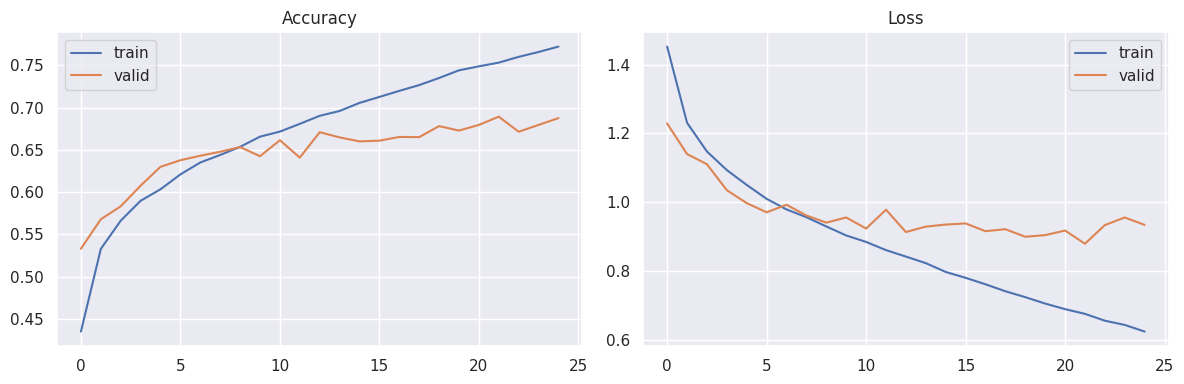

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

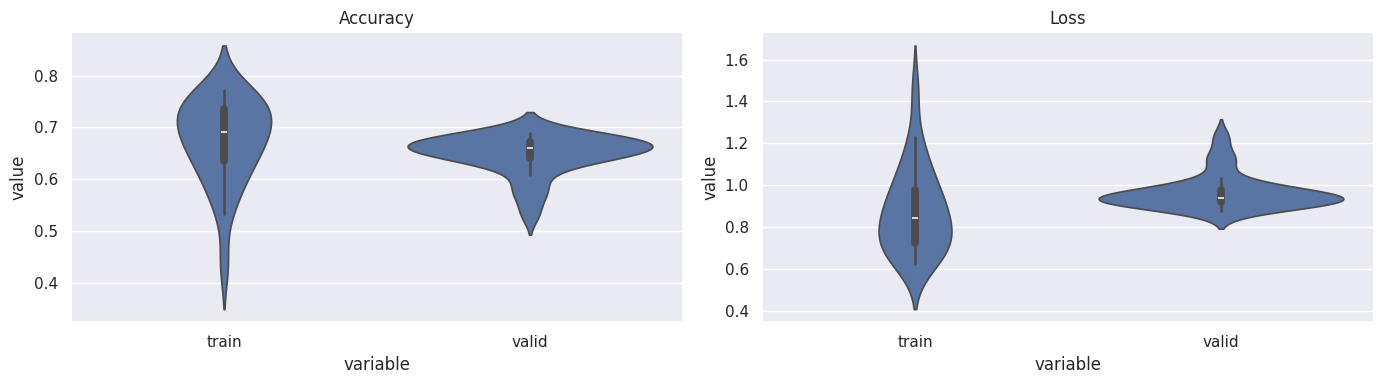

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu))
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss))
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 2s 14ms/step
total wrong validation predictions: 1121


              precision    recall  f1-score   support

           0       0.61      0.64      0.62       495
           1       0.61      0.49      0.55        55
           2       0.61      0.42      0.50       512
           3       0.85      0.91      0.88       899
           4       0.55      0.61      0.58       608
           5       0.78      0.79      0.78       400
           6       0.65      0.66      0.65       620

    accuracy                           0.69      3589
   macro avg       0.66      0.64      0.65      3589
weighted avg       0.68      0.69      0.68      3589



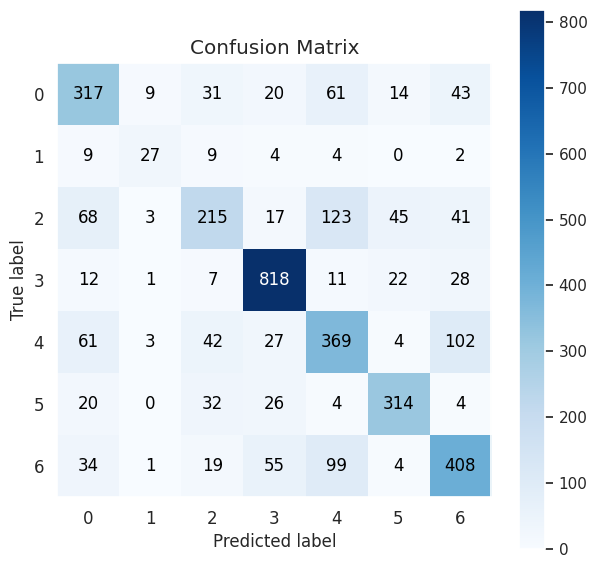

In [ ]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 17ms/step


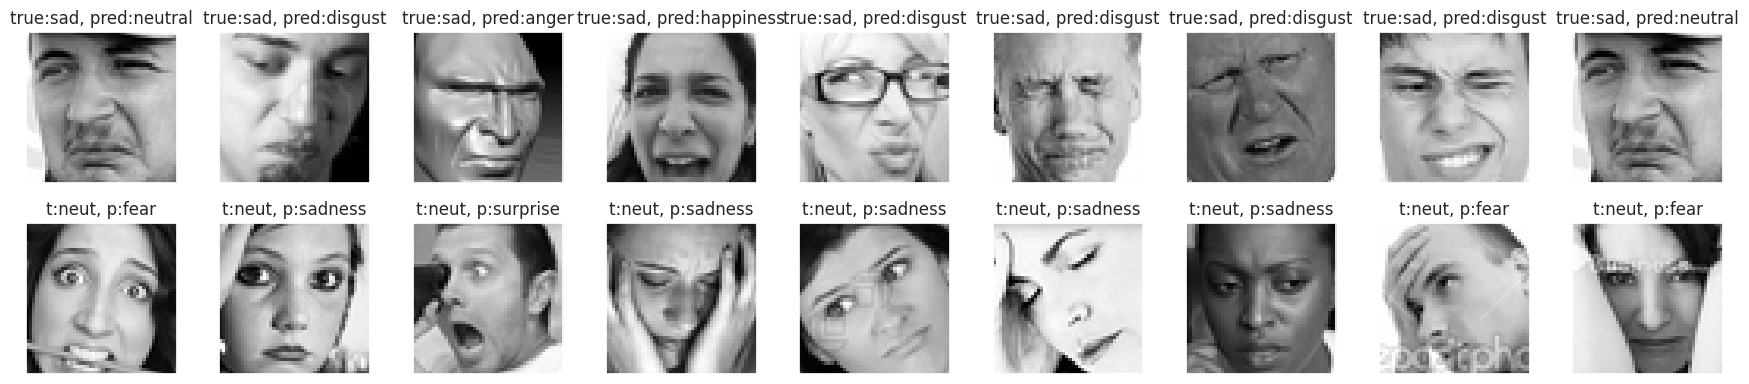

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()

## **RESNET-50**

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 87% 105M/121M [00:00<00:00, 167MB/s] 
100% 121M/121M [00:00<00:00, 138MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
mkdir train_dir

In [ ]:
mkdir test_dir

In [ ]:
train_dir = '/content/images/train'
test_dir = '/content/images/validation'

In [ ]:
!pip install augmentor

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import Augmentor
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from efficientnet.tfkeras import EfficientNetB0
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import set_config
from keras.utils import plot_model

(48, 48)


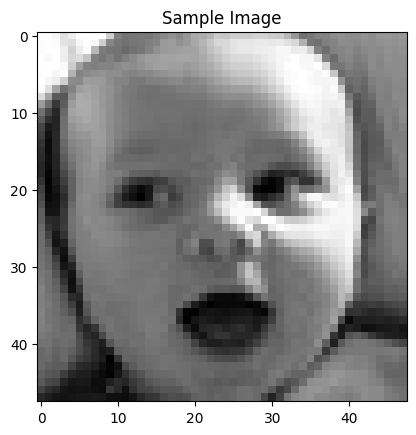

In [ ]:
image_path = '/content/images/train/happy/10001.jpg'
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.title('Sample Image')
plt.show()

In [ ]:
def augment_data(folder, num_of_images, ):
    p = Augmentor.Pipeline(folder, folder)

    p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    p.flip_left_right(probability=0.5)
    p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)

    p.sample(num_of_images)

    print(f"{num_of_images} augmented images have been saved to {folder}.")

In [ ]:
angry_folder = '/content/images/train/angry'
augment_data(angry_folder, 3000)

Initialised with 3993 image(s) found.
Output directory set to /content/images/train/angry.

Processing <PIL.Image.Image image mode=L size=48x48 at 0x7B6DE169E380>: 100%|██████████| 3000/3000 [00:08<00:00, 337.64 Samples/s]

3000 augmented images have been saved to /content/images/train/angry.


In [ ]:
disgust_folder = '/content/images/train/disgust'
augment_data(disgust_folder, 6500)

Initialised with 436 image(s) found.
Output directory set to /content/images/train/disgust.

Processing <PIL.Image.Image image mode=L size=48x48 at 0x7B6DE150CB20>: 100%|██████████| 6500/6500 [00:15<00:00, 418.65 Samples/s]

6500 augmented images have been saved to /content/images/train/disgust.


In [ ]:
fear_folder = '/content/images/train/fear'
augment_data(fear_folder, 3000)

Initialised with 4103 image(s) found.
Output directory set to /content/images/train/fear.

Processing <PIL.Image.Image image mode=L size=48x48 at 0x7B6DE171AFB0>: 100%|██████████| 3000/3000 [00:08<00:00, 370.01 Samples/s]

3000 augmented images have been saved to /content/images/train/fear.


In [ ]:
neutral_folder = '/content/images/train/neutral'
augment_data(neutral_folder, 2000)

Initialised with 4982 image(s) found.
Output directory set to /content/images/train/neutral.

Processing <PIL.Image.Image image mode=L size=48x48 at 0x7B6DE92426B0>: 100%|██████████| 2000/2000 [00:04<00:00, 403.46 Samples/s]

2000 augmented images have been saved to /content/images/train/neutral.


In [ ]:
sad_folder = '/content/images/train/sad'
augment_data(sad_folder, 2000)

Initialised with 4938 image(s) found.
Output directory set to /content/images/train/sad.

Processing <PIL.Image.Image image mode=L size=48x48 at 0x7B6DE91A08E0>: 100%|██████████| 2000/2000 [00:05<00:00, 398.62 Samples/s]

2000 augmented images have been saved to /content/images/train/sad.


In [ ]:
surprise_folder = '/content/images/train/surprise'
augment_data(surprise_folder, 3500)

Initialised with 3205 image(s) found.
Output directory set to /content/images/train/surprise.

Processing <PIL.Image.Image image mode=L size=48x48 at 0x7B6DE1726890>: 100%|██████████| 3500/3500 [00:09<00:00, 357.06 Samples/s]

3500 augmented images have been saved to /content/images/train/surprise.


In [ ]:

train_data = []
test_data = []

def get_data(directory):
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                data.append({'label': label, 'path': image_path})
    return data


In [ ]:
train_df = pd.DataFrame(get_data(train_dir))
test_df = pd.DataFrame(get_data(test_dir))

In [ ]:
train_df.head()

label                                 path
0   sad   /content/images/train/sad/6067.jpg
1   sad  /content/images/train/sad/33280.jpg
2   sad  /content/images/train/sad/19153.jpg
3   sad   /content/images/train/sad/6434.jpg
4   sad  /content/images/train/sad/12039.jpg

In [ ]:
test_df.head()

label                                      path
0   sad  /content/images/validation/sad/22690.jpg
1   sad  /content/images/validation/sad/26378.jpg
2   sad   /content/images/validation/sad/7623.jpg
3   sad    /content/images/validation/sad/977.jpg
4   sad  /content/images/validation/sad/11582.jpg

In [ ]:
print(train_df.shape)
print(test_df.shape)

(48821, 2)
(7066, 2)


In [ ]:
test_df['label'].unique()

array(['sad', 'disgust', 'happy', 'surprise', 'fear', 'neutral', 'angry'],
      dtype=object)

In [ ]:
img_width, img_height = 48, 48
batch_size = 64
y_col = 'label'
x_col = 'path'
no_of_classes = len(train_df[y_col].unique())

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/images/train",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 48821 files belonging to 7 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/images/validation",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 7066 files belonging to 7 classes.


In [ ]:
resnet_model = tf.keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(48,48,3),
                   pooling='max',classes=no_of_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=True

resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.07)))
resnet_model.add(tf.keras.layers.Dropout(0.6))
resnet_model.add(tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.07)))
resnet_model.add(tf.keras.layers.Dense(7, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 24)                49176     
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 7)                 175       
                                                                 
Total params: 23637663 (90.17 MB)
Trainable params: 2358

In [ ]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

In [ ]:
resnet_history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/20
763/763 [==============================] - 102s 83ms/step - loss: 2.2976 - accuracy: 0.3168 - val_loss: 1.6446 - val_accuracy: 0.3892
Epoch 2/20
763/763 [==============================] - 54s 71ms/step - loss: 1.5168 - accuracy: 0.4287 - val_loss: 1.4333 - val_accuracy: 0.4989
Epoch 3/20
763/763 [==============================] - 55s 73ms/step - loss: 1.4338 - accuracy: 0.4580 - val_loss: 1.4498 - val_accuracy: 0.4905
Epoch 4/20
763/763 [==============================] - 55s 72ms/step - loss: 1.3693 - accuracy: 0.4828 - val_loss: 1.5972 - val_accuracy: 0.4186
Epoch 5/20
763/763 [==============================] - 53s 70ms/step - loss: 1.3171 - accuracy: 0.5040 - val_loss: 1.5515 - val_accuracy: 0.4544
Epoch 6/20
763/763 [==============================] - 54s 70ms/step - loss: 1.2674 - accuracy: 0.5297 - val_loss: 1.4096 - val_accuracy: 0.4924
Epoch 7/20
763/763 [==============================] - 54s 70ms/step - loss: 1.2279 - accuracy: 0.5457 - val_loss: 1.4922 - val_accuracy

In [ ]:
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(val_ds)
print(f"Test Loss: {resnet_test_loss}, Test Accuracy: {resnet_test_accuracy * 100:.2f}%")

111/111 [==============================] - 2s 17ms/step - loss: 1.4096 - accuracy: 0.4924
Test Loss: 1.4096307754516602, Test Accuracy: 49.24%


In [ ]:
resnet_model.save('resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


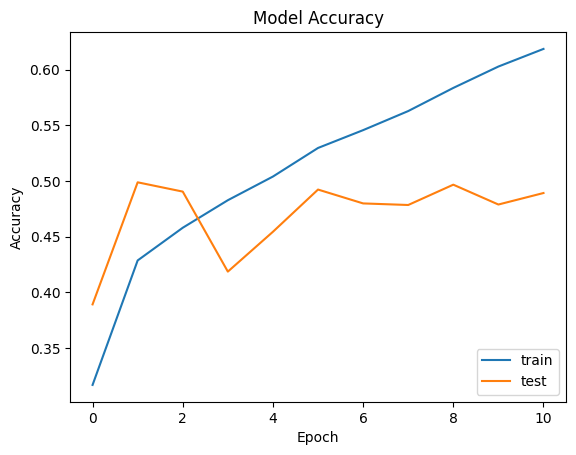

In [ ]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
def test_model(model):
    prefix = "/content/images/validation"

    classes = os.listdir(prefix)

    choices = []

    for i in range(6):
        temp = {}
        for j in range(5):
            ch = random.choice(classes)
            li = os.listdir(prefix+"/"+ch)
            file_ = prefix+"/"+ch+"/"+random.choice(li)
            temp[file_] = ch
        choices.append(temp)


    plt.figure(figsize=(20, 20))
    n = 4
    im = 8
    ct = 1
    for row in choices:
        for i in row:
            ax = plt.subplot(im, n, ct)
            ct = ct + 1
            image =  cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            image = np.expand_dims(image, 0)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("True: {}, Predicted:{}".format(row[i], train_ds.class_names[np.argmax(model.predict(image)[0])]))
    plt.show()


1/1 [==============================] - 0s 21ms/step


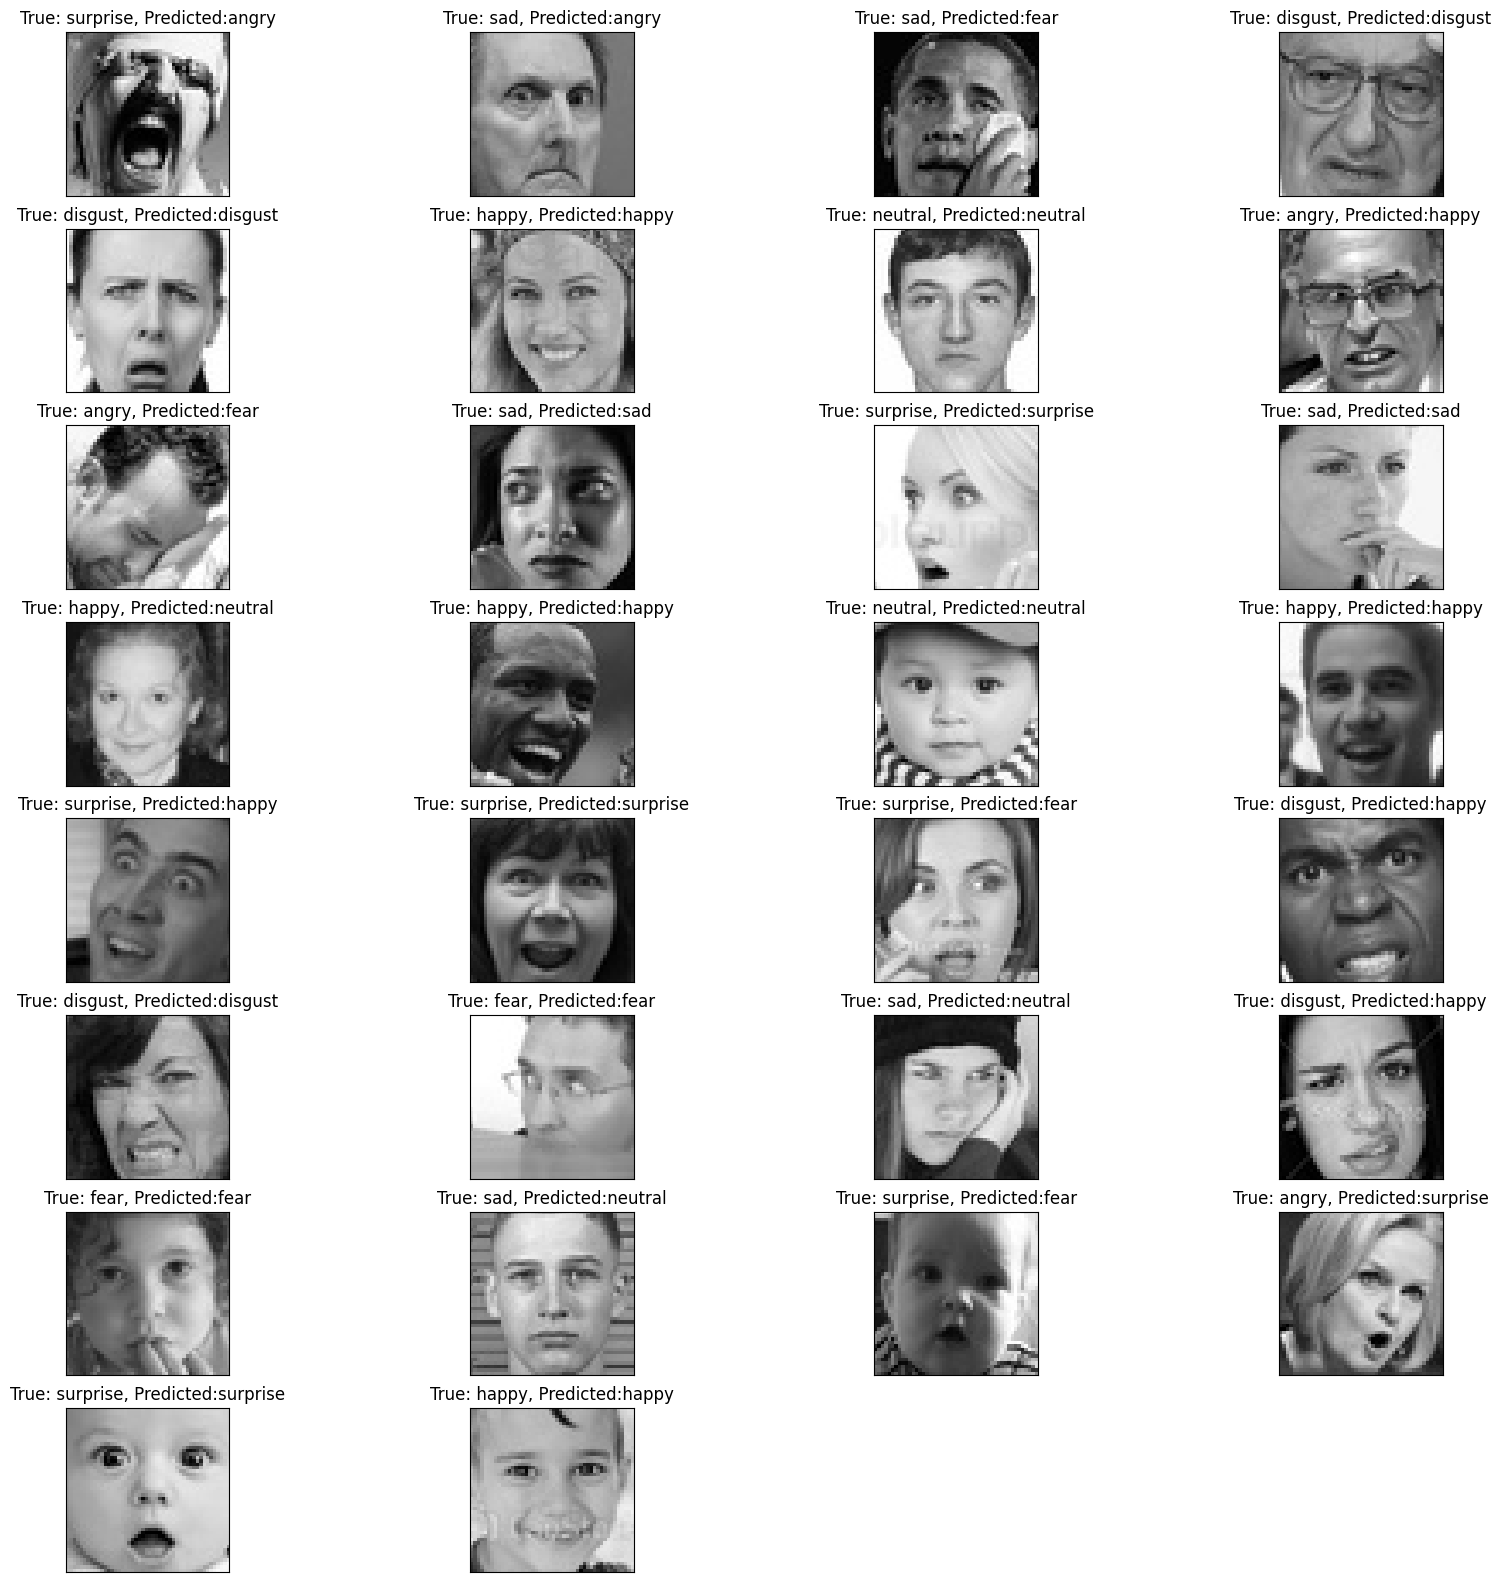

In [ ]:
test_model(resnet_model)

## **MobileNet**

In [ ]:
image_size = (48, 48)
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 48821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
mobilenet_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobilenet_model = tf.keras.models.Sequential()
mobilenet_model.add(mobilenet_base_model)
mobilenet_model.add(GlobalMaxPooling2D())
mobilenet_model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.07)))
mobilenet_model.add(Dropout(0.6))
mobilenet_model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.07)))
mobilenet_model.add(Dense(7, activation='softmax'))

In [ ]:
mobilenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1, 1, 1024)        3228864   
 onal)                                                           
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_3 (Dense)             (None, 20)                20500     
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 7)                

In [ ]:
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20
)

Epoch 1/20
763/763 [==============================] - 49s 45ms/step - loss: 2.2185 - accuracy: 0.3475 - val_loss: 1.8049 - val_accuracy: 0.3539
Epoch 2/20
763/763 [==============================] - 42s 55ms/step - loss: 1.4758 - accuracy: 0.4644 - val_loss: 1.5204 - val_accuracy: 0.4812
Epoch 3/20
763/763 [==============================] - 35s 46ms/step - loss: 1.3879 - accuracy: 0.4972 - val_loss: 1.4287 - val_accuracy: 0.5112
Epoch 4/20
763/763 [==============================] - 34s 45ms/step - loss: 1.3352 - accuracy: 0.5190 - val_loss: 1.5025 - val_accuracy: 0.4857
Epoch 5/20
763/763 [==============================] - 34s 45ms/step - loss: 1.2890 - accuracy: 0.5448 - val_loss: 1.3372 - val_accuracy: 0.5543
Epoch 6/20
763/763 [==============================] - 30s 40ms/step - loss: 1.2444 - accuracy: 0.5626 - val_loss: 1.3095 - val_accuracy: 0.5490
Epoch 7/20
763/763 [==============================] - 31s 40ms/step - loss: 1.2100 - accuracy: 0.5808 - val_loss: 1.2593 - val_accuracy:

In [ ]:
mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(test_generator)

111/111 [==============================] - 3s 28ms/step - loss: 1.4253 - accuracy: 0.5924


In [ ]:
print(f"Test Loss: {mobilenet_test_loss:.2f}")
print(f"Train Accuracy: {mobilenet_history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {mobilenet_test_accuracy * 100:.2f}%")

Test Loss: 1.43
Train Accuracy: 77.51%
Test Accuracy: 59.24%


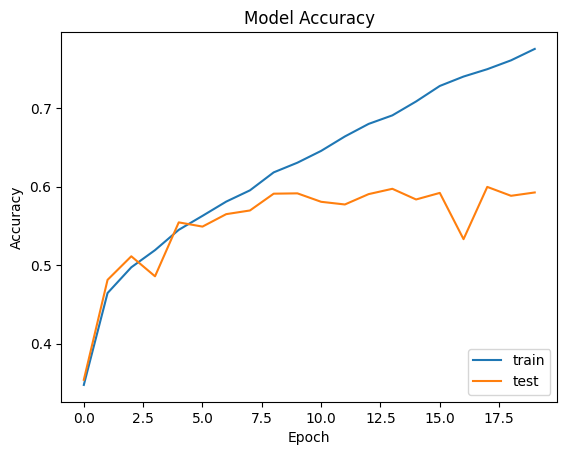

In [ ]:
plt.plot(mobilenet_history.history['accuracy'])
plt.plot(mobilenet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
mobilenet_model.save('mobilenet_model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/mobilenet_model.h5')

1/1 [==============================] - 0s 18ms/step


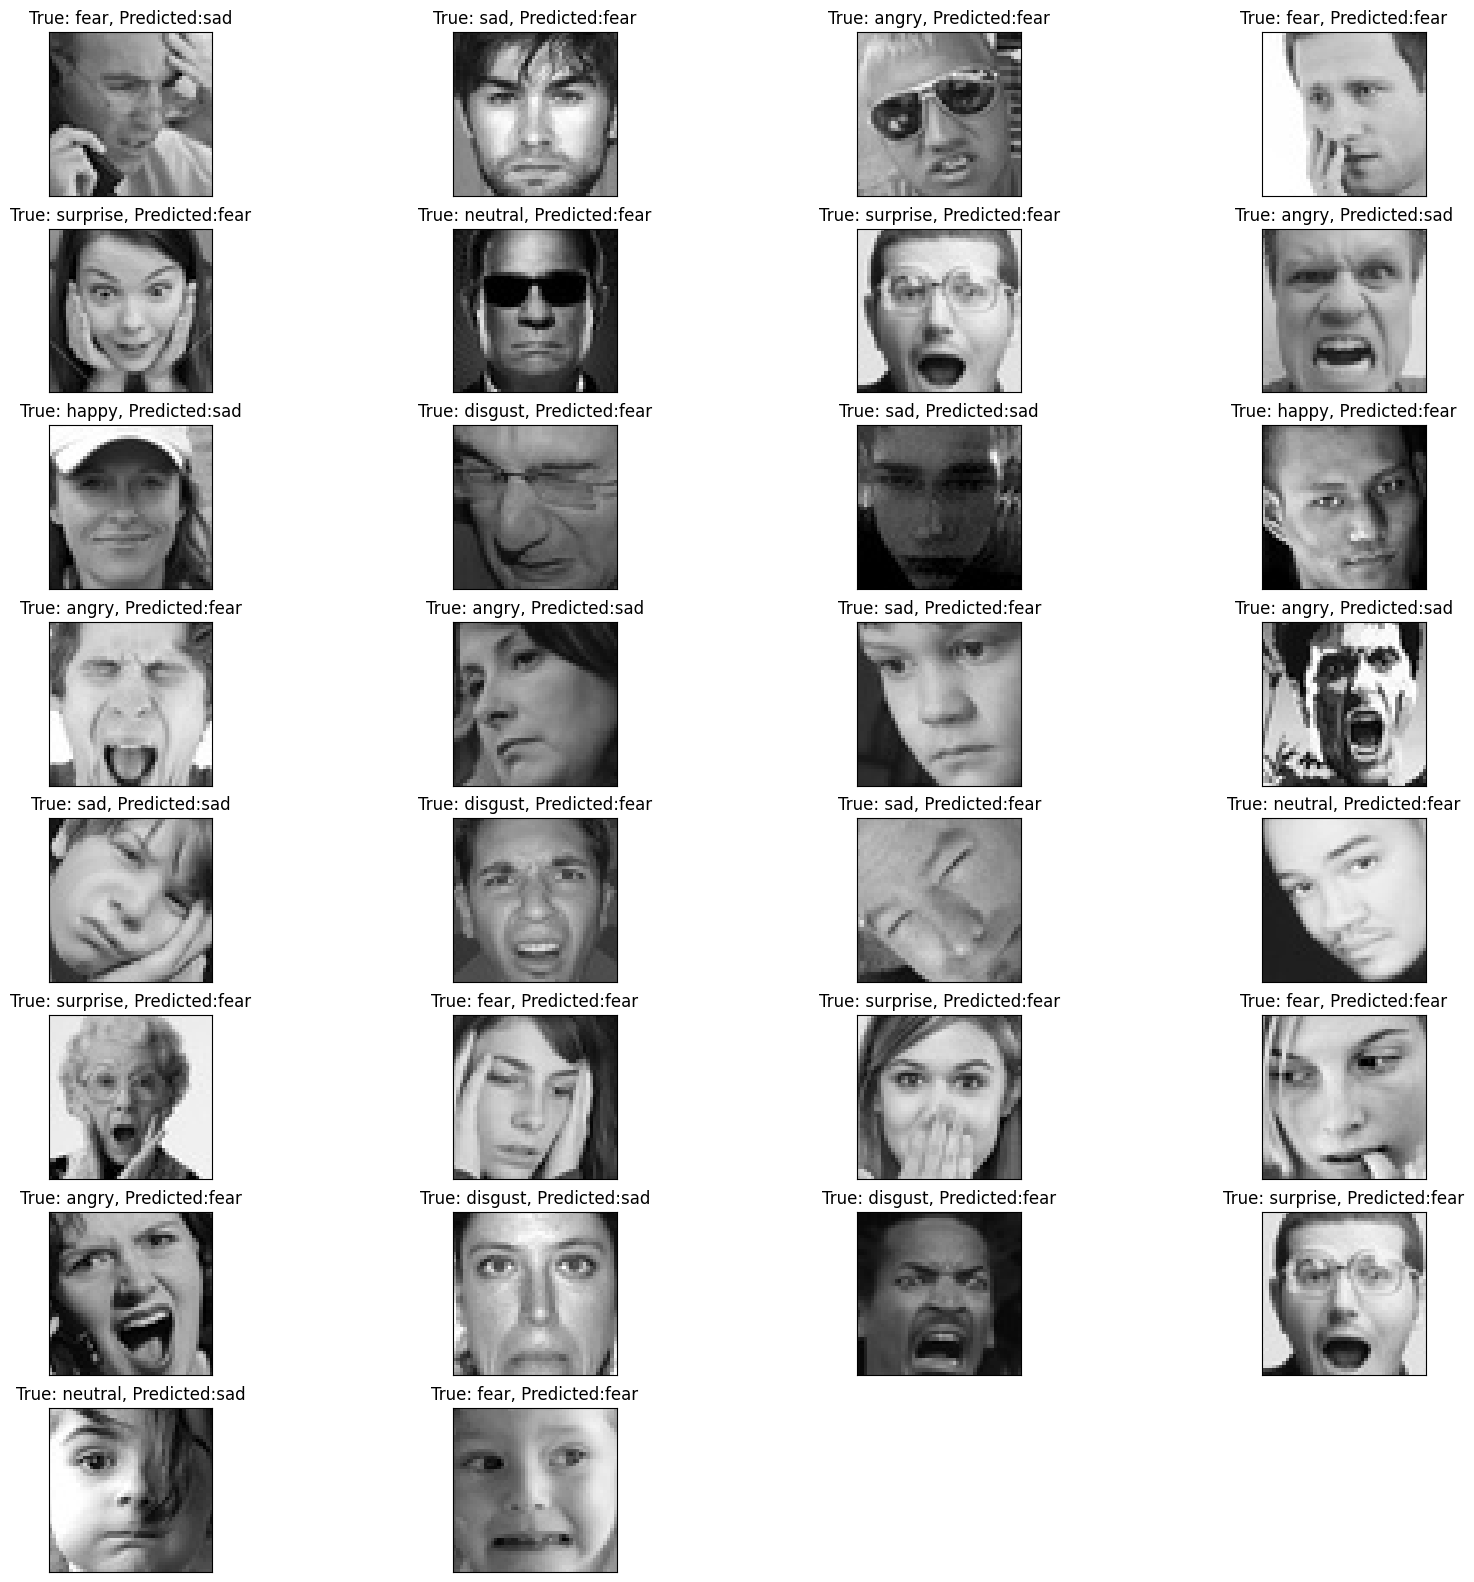

In [ ]:
test_model(model)

# **Attention Mechanism Based FER**

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 96% 273M/285M [00:01<00:00, 224MB/s]
100% 285M/285M [00:01<00:00, 212MB/s]


In [ ]:
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import os
os.makedirs('data', exist_ok=True)
!mv train.csv test.csv data/

In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from __future__ import print_function
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

from __future__ import print_function
import argparse
import os
import cv2
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


In [ ]:
class Generate_data():
    def __init__(self, datapath):
        """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_images
        [Note] that you have to split the public and private from fer2013 file
        """
        self.data_path = datapath

    def split_test(self, val_filename= 'val'):
        """
        Helper function to split the validation and train data from general train file.
            params:-
                data_path = path to the folder that contains the train data file
        """
        train_csv_path = self.data_path +"/"+ 'train.csv'
        train = pd.read_csv(train_csv_path)
        validation_data = pd.DataFrame(train.iloc[:3589,:])
        train_data = pd.DataFrame(train.iloc[3589:,:])
        train_data.to_csv(self.data_path+"/train.csv")
        validation_data.to_csv(self.data_path+"/"+val_filename+".csv")
        print("Splitted the test file into validation & final test file")

    def str_to_image(self, str_img = ' '):
        '''
        Convert string pixels from the csv file into image object
            params:- take an image string
            return :- return PIL image object
        '''
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48)
        return Image.fromarray(imgarray)

    def save_images(self, datatype='train'):
        '''
        save_images is a function responsible for saving images from data files e.g(train, test) in a desired folder
            params:-
            datatype= str e.g (train, val, test)
        '''
        foldername= self.data_path+"/"+datatype
        csvfile_path= self.data_path+"/"+datatype+'.csv'
        if not os.path.exists(foldername):
            os.mkdir(foldername)

        data = pd.read_csv(csvfile_path)
        images = data['pixels'] #dataframe to series pandas
        numberofimages = images.shape[0]
        for index in tqdm(range(numberofimages)):
            img = self.str_to_image(images[index])
            img.save(os.path.join(foldername,'{}{}.jpg'.format(datatype,index)),'JPEG')
        print('Done saving {} data'.format((foldername)))

In [ ]:
class Plain_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.csv_file.head()
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

#Helper function
def eval_data_dataloader(csv_file,img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(csv_file=csv_file,img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    imgnumpy = imgg.numpy()
    imgt = imgnumpy.squeeze()
    plt.imshow(imgt)
    plt.show()

In [ ]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(validation_dataset)
        val_acc = val_correct.double() / len(validation_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Accuracy {:.3f}% \tValidation Accuracy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")


if __name__ == '__main__':

    epochs = 100
    lr = 0.005
    batchsize = 128
    train = True
    datapath = "/content/data"

    generate_dataset = Generate_data(datapath)
    generate_dataset.split_test()
    generate_dataset.save_images('train')
    generate_dataset.save_images('test')
    generate_dataset.save_images('val')

    if train:
        net = Deep_Emotion()
        net.to(device)
        print("Model archticture: ", net)
        traincsv_file = datapath+'/'+'train.csv'
        validationcsv_file = datapath+'/'+'val.csv'
        train_img_dir = datapath+'/'+'train/'
        validation_img_dir = datapath+'/'+'val/'

        transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
        train_dataset= Plain_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)
        validation_dataset= Plain_Dataset(csv_file=validationcsv_file, img_dir = validation_img_dir, datatype = 'val', transform = transformation)
        train_loader= DataLoader(train_dataset,batch_size=batchsize,shuffle = True,num_workers=0)
        val_loader=   DataLoader(validation_dataset,batch_size=batchsize,shuffle = True,num_workers=0)

        criterion= nn.CrossEntropyLoss()
        optmizer= optim.Adam(net.parameters(),lr= lr)
        Train(epochs, train_loader, val_loader, criterion, optmizer, device)

Splitted the test file into validation & final test file


100%|██████████| 25120/25120 [00:14<00:00, 1691.88it/s]


Done saving /content/data/train data


100%|██████████| 7178/7178 [00:03<00:00, 1935.76it/s]


Done saving /content/data/test data


100%|██████████| 3589/3589 [00:01<00:00, 1993.80it/s]


Done saving /content/data/val data
Model archticture:  Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, paddi

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.01345861 	Validation Loss 0.01309929 	Training Accuracy 31.027% 	Validation Accuracy 34.689%
Epoch: 2 	Training Loss: 0.01237242 	Validation Loss 0.01328910 	Training Accuracy 38.404% 	Validation Accuracy 34.578%
Epoch: 3 	Training Loss: 0.01178305 	Validation Loss 0.01224577 	Training Accuracy 41.377% 	Validation Accuracy 41.683%
Epoch: 4 	Training Loss: 0.01147299 	Validation Loss 0.01207089 	Training Accuracy 43.583% 	Validation Accuracy 41.711%
Epoch: 5 	Training Loss: 0.01128974 	Validation Loss 0.01217389 	Training Accuracy 44.371% 	Validation Accuracy 42.101%
Epoch: 6 	Training Loss: 0.01114716 	Validation Loss 0.01177126 	Training Accuracy 44.805% 	Validation Accuracy 43.327%
Epoch: 7 	Training Loss: 0.01101574 	Validation Loss 0.01169459 	Training Accuracy 45.601% 	Validation Accuracy 42.937%
Epoch: 8 	Training Loss: 0.01090546 	Validation Loss 0.01165710 	Training Accuracy 46.298% 	Validation Accuracy 44.469%
Epoch: 9 	Training Loss: 0.01085642 	Val

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datapath = "/content/data"

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
dataset = Plain_Dataset(csv_file=datapath+'/val.csv',img_dir = datapath+'/'+'val/',datatype = 'val',transform = transformation)
test_loader =  DataLoader(dataset,batch_size=64,num_workers=0)

net = Deep_Emotion()
print("Deep Emotion:-", net)
net.load_state_dict(torch.load("/content/deep_emotion-100-128-0.005.pt"))
net.to(device)
net.eval()

#Model Evaluation on test data
classes = ('Angry', 'Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral')
total = []

with torch.no_grad():
    for data, labels in test_loader:
          data, labels = data.to(device), labels.to(device)
          outputs = net(data)
          pred = F.softmax(outputs,dim=1)
          classs = torch.argmax(pred,1)
          wrong = torch.where(classs != labels,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
          acc = 1- (torch.sum(wrong) / 64)
          total.append(acc.item())

print('Accuracy of the network on the test images: %d %%' % (100 * np.mean(total)))

Deep Emotion:- Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Accuracy of the network on the test images: 48 %


# **Graph Convolutional Network based FER**

In [ ]:
!pip install opencv-python-headless -q
import cv2
import torch
import torchvision
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import json


In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self, num_features, num_filters, threshold):
        super(GraphConvolution, self).__init__()
        self.num_features = num_features
        self.num_filters = num_filters
        self.threshold = threshold
        self.W = nn.Parameter(torch.Tensor(num_features, num_filters))
        nn.init.xavier_uniform_(self.W)

    def forward(self, x, distance_matrix):
        A = (distance_matrix < self.threshold).float()
        D = torch.sum(A, dim=-1, keepdim=True)
        D = torch.diag_embed(D.squeeze())
        D_inv_sqrt = torch.inverse(torch.sqrt(D))
        A = torch.matmul(torch.matmul(D_inv_sqrt, A), D_inv_sqrt)
        x = torch.matmul(A, x)
        x = torch.matmul(x, self.W)
        return x

In [ ]:
def create_adjacency_matrix(landmarks):
    adjacency_matrices = []
    for landmark in tqdm(landmarks, desc="Creating Adjacency Matrix"):
        num_landmarks = len(landmark)
        adjacency_matrix = torch.zeros(num_landmarks, num_landmarks)

        for i in range(num_landmarks):
            for j in range(i + 1, num_landmarks):
                distance = torch.norm(torch.tensor(landmark[i]) - torch.tensor(landmark[j]))
                adjacency_matrix[i, j] = distance
                adjacency_matrix[j, i] = distance

        adjacency_matrices.append(adjacency_matrix)

    return adjacency_matrices

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dl/fer2013_landmarks.csv')
df.head()

id                                          landmarks  \
0   0  [[-1.0, 16.0], [-1.0, 22.0], [-2.0, 28.0], [-1...   
1   1  [[4.0, 25.0], [5.0, 29.0], [6.0, 33.0], [9.0, ...   
2   2  [[7.0, 11.0], [6.0, 16.0], [5.0, 20.0], [5.0, ...   
3   3  [[2.0, 18.0], [2.0, 23.0], [2.0, 28.0], [3.0, ...   
4   4  [[3.0, 20.0], [3.0, 25.0], [4.0, 30.0], [6.0, ...   

                               emotion  
0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
2  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]  
3  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [ ]:
X = torch.tensor([ast.literal_eval(x) for x in df.landmarks], dtype=torch.float32)
y = torch.tensor([ast.literal_eval(x) for x in df.emotion], dtype=torch.float32)

In [ ]:
A = create_adjacency_matrix(X)

Creating Adjacency Matrix:   0%|          | 0/35887 [00:00<?, ?it/s]<ipython-input-7-3441ca1395c8>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance = torch.norm(torch.tensor(landmark[i]) - torch.tensor(landmark[j]))
Creating Adjacency Matrix: 100%|██████████| 35887/35887 [58:32<00:00, 10.22it/s]


In [ ]:
combined_matrices = torch.stack(A)
torch.save(combined_matrices, "combined_adjacency_matrices")

In [ ]:
combined_matrices = torch.load("/content/drive/MyDrive/dl/combined_adjacency_matrices")

A = []

# Iterate over the combined_matrices tensor
for matrix in combined_matrices:
    # Append each matrix to the list
    A.append(matrix)

In [ ]:
A = np.array(A, dtype=np.float32)
A.shape

(35887, 68, 68)

In [ ]:
X_train, X_test, A_train, A_test, y_train, y_test = train_test_split(X, A, y, test_size=0.1)
X_train, X_val, A_train, A_val, y_train, y_val = train_test_split(X_train, A_train, y_train, test_size=0.1)

In [ ]:
batch_size = 64
node_shape = (68, 2)
adjacency_shape = (68, 68)
threshold = 15

In [ ]:
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(A_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(A_val), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(A_test), torch.tensor(y_test))

# Create PyTorch DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


<ipython-input-11-766bec2f3b91>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(A_train), torch.tensor(y_train))
<ipython-input-11-766bec2f3b91>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(A_val), torch.tensor(y_val))
<ipython-input-11-766bec2f3b91>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(A_test), torch.tensor(y_test))


In [ ]:
class GraphConvolutionalNetwork(nn.Module):
    def __init__(self, node_shape, adjacency_shape, threshold):
        super(GraphConvolutionalNetwork, self).__init__()

        # Define the layers
        self.gc1 = GraphConvolution(num_features=node_shape[1], num_filters=100, threshold=threshold)
        self.gc2 = GraphConvolution(num_features=100, num_filters=100, threshold=threshold)
        self.gc3 = GraphConvolution(num_features=100, num_filters=100, threshold=threshold)
        self.gc4 = GraphConvolution(num_features=100, num_filters=100, threshold=threshold)
        self.gc5 = GraphConvolution(num_features=100, num_filters=100, threshold=threshold)
        self.gc6 = GraphConvolution(num_features=100, num_filters=10, threshold=threshold)
        self.global_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(10, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 7)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, i, a):
        # Forward pass through the layers
        x = self.gc1(i, a)
        x = self.gc2(x, a)
        x = self.gc3(x, a)
        x = self.gc4(x, a)
        x = self.gc5(x, a)
        x = self.gc6(x, a)
        x = x.to_dense()
        x = self.global_pooling(x.permute(0, 2, 1))  # Permute to match PyTorch's expected input format
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [ ]:
gcn = GraphConvolutionalNetwork(node_shape=(68, 2), adjacency_shape=(68, 68), threshold=15)

In [ ]:
gcn

GraphConvolutionalNetwork(
  (gc1): GraphConvolution()
  (gc2): GraphConvolution()
  (gc3): GraphConvolution()
  (gc4): GraphConvolution()
  (gc5): GraphConvolution()
  (gc6): GraphConvolution()
  (global_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
learning_rate = 1e-3
num_epochs = 10
weight_decay = 0.0001
label_smoothing = 0.1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_gcn = optim.AdamW(gcn.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
# Set model to training mode
gcn.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training dataset
    for i, data in enumerate(train_loader, 0):
        # Get inputs
        inputs, adjacency_matrix, labels = data

        # Zero the gradients
        optimizer_gcn.zero_grad()

        # Forward pass
        outputs = gcn(inputs, adjacency_matrix)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer_gcn.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()  # Convert one-hot encoded labels to class indices

        # Print statistics every 100 batches
        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100}')
            running_loss = 0.0

    # Print epoch-level statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_acc}%')

print('Finished Training')


Epoch [1/10], Batch [100/455], Loss: 1.920884404182434
Epoch [1/10], Batch [200/455], Loss: 1.915265941619873
Epoch [1/10], Batch [300/455], Loss: 1.91870344042778
Epoch [1/10], Batch [400/455], Loss: 1.9133909296989442
Epoch [1/10], Loss: 0.23166046692774847, Accuracy: 24.907114352552636%
Epoch [2/10], Batch [100/455], Loss: 1.9143284344673157
Epoch [2/10], Batch [200/455], Loss: 1.9180784547328948
Epoch [2/10], Batch [300/455], Loss: 1.918078430891037
Epoch [2/10], Batch [400/455], Loss: 1.9141722083091737
Epoch [2/10], Loss: 0.23180927627689235, Accuracy: 24.907114352552636%
Epoch [3/10], Batch [100/455], Loss: 1.9133909451961517
Epoch [3/10], Batch [200/455], Loss: 1.9182346880435943
Epoch [3/10], Batch [300/455], Loss: 1.9171409344673156
Epoch [3/10], Batch [400/455], Loss: 1.9180784285068513
Epoch [3/10], Loss: 0.23132850599812937, Accuracy: 24.907114352552636%
Epoch [4/10], Batch [100/455], Loss: 1.9146409356594085
Epoch [4/10], Batch [200/455], Loss: 1.9182346916198731
Epoch [4

In [ ]:
# Define a counter
I = 0

# Iterate over the named parameters of the model
for name, param in gcn.named_parameters():
    # Modify the parameter's name
    param._handle_name = name + "_" + str(I)

    # Increment the counter
    I += 1


In [ ]:
# Get the state_dict of the model
gcn_state_dict = gcn.state_dict()

# Define the directory to save the model
model_dir = "model_dir"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the state_dict to a file
torch.save(gcn_state_dict, os.path.join(model_dir, 'fer13_gcn_weights.pth'))


In [ ]:
# Assume single_X and single_A are torch tensors
A = torch.tensor(A)
X = torch.tensor(X)

# Add batch dimension to the single data point
single_X = X.unsqueeze(0)  # Add batch dimension to node features
single_A = A.unsqueeze(0)  # Add batch dimension to adjacency matrix

# Set model to evaluation mode
gcn.eval()

# Make inference on the single data point
with torch.no_grad():
    predictions = gcn(single_X, single_A)

# Convert predictions to probabilities using softmax
predictions_prob = torch.softmax(predictions, dim=1)

# Convert predictions to class labels
predicted_classes = torch.argmax(predictions_prob, dim=1)


# **Real Time FER in Local Environment**

Trained the model (as above given code for attention mechanism based FER) and saved the weights. Then loaded the model in the local environment (since the real time face detection using opencv requires a CascadeClassifier which will not be able to run in colab) and performed the real time face emotion recognition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchvision import transforms
from PIL import Image

class Deep_Emotion(nn.Module):
    def _init_(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self)._init_()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Deep_Emotion()
net.load_state_dict(torch.load("deep_emotion-100-128-0.005.pt", map_location=device))

cam = True
classes = ('Angry', 'Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral')
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])



#helper_function for real time testing
def load_img(path):
    img = Image.open(path)
    img = transformation(img).float()
    img = torch.autograd.Variable(img,requires_grad = True)
    img = img.unsqueeze(0)
    return img.to(device)

if cam:
    # Load the cascade
    face_cascade = cv2.CascadeClassifier('Cascades/haarcascade_frontalface_default.xml')

    # To capture video from webcam.
    cap = cv2.VideoCapture(0)
    cap.set(3,640) # set Width
    cap.set(4,480) # set Height
    while True:
        # Read the frame
        _, img = cap.read()
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect the faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        # Draw the rectangle around each face
        # print(faces,' adfj;af')
        if len(faces)==0:
            continue
        for (x, y, w, h) in faces:
            roi = img[y:y+h, x:x+w]
            roi = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
            roi = cv2.resize(roi,(48,48))

            roi = transformation(roi)
            roi = roi[None, :, :, :]
            # cv2.imwrite("roi.jpg", roi)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # print(roi)
        imgg = roi
        out = net(imgg)
        pred = F.softmax(out)
        classs = torch.argmax(pred,1)
        wrong = torch.where(classs != 3,torch.tensor([1.]),torch.tensor([0.]))
        classs = torch.argmax(pred,1)
        prediction = classes[classs.item()]

        font = cv2.FONT_HERSHEY_SIMPLEX
        org = (50, 50)
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2
        img = cv2.putText(img, prediction, org, font,
                       fontScale, color, thickness, cv2.LINE_AA)

        cv2.imshow('img', img)
        # Stop if (Q) key is pressed
        k = cv2.waitKey(30)
        if k==ord("q"):
            break

    # Release the VideoCapture object
    cap.release()

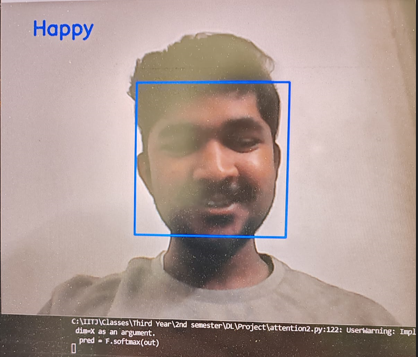

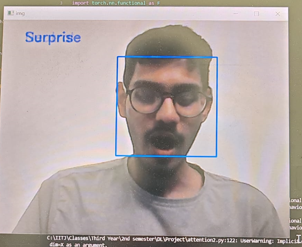

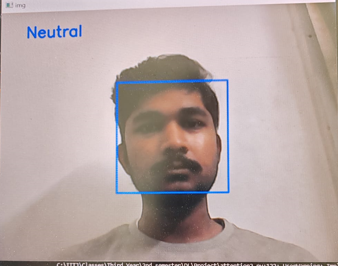

## **Wrong Classification**
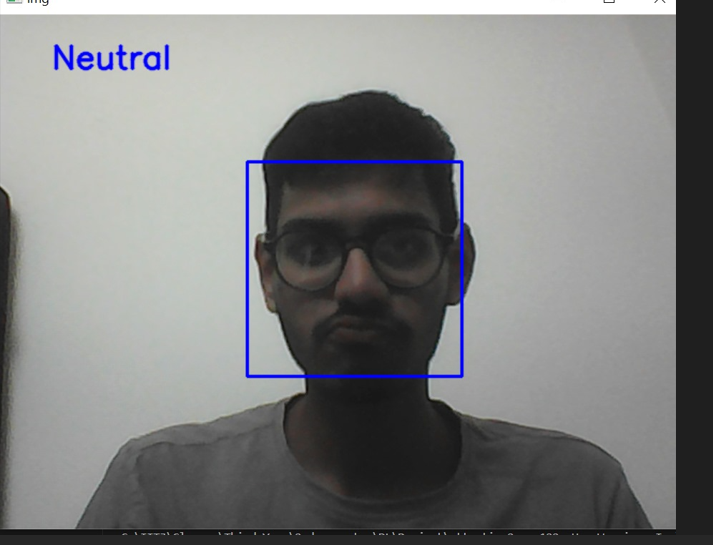